In [1]:
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\First\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Как уже было сказано во введении, с точки зрения машинного обучения необходимо решить задачу **регрессии**. В нашем датасете присутствуют категориальные переменные и, вообще говоря, для многих регрессионных моделей необходимо сделать перевод этих переменных в числовые. Но для начала воспользуемся библиотекой **CatBoost** от Yandex, которая умеет работать с категориальными признаками. Для оценки качества предлагается использовать метрику MAPE. 

## CatBoostRegressor

Зададим настройки для расчёта: версию решения, воспроизводимость решения, число фолдов для кросс-валидации, размер тестовой выборки, а также число итераций и параметр скорости обучения для CatBoost (были подобраны в ручном режиме)

In [2]:
VERSION = 1
RANDOM_SEED = 42
N_FOLDS = 5
VAL_SIZE = 0.33
# CATBOOST
ITERATIONS = 3500
LR = 0.05

Загрузим данные:

In [3]:
train = pd.read_csv('train_stack_tax.csv')
test = pd.read_csv('test_stack_tax.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Посмотрим на корреляцию числовых признаков:

In [4]:
numeric_idx = [3, 5, 6, 8, 9, 10, 17, 71, 15]
print(f'Числовые признаки:\n{list(train.columns[numeric_idx])}')

Числовые признаки:
['model_date_begin', 'number_of_doors', 'age', 'engine_displacement', 'engine_power', 'mileage', 'exp_year', 'tax', 'price']


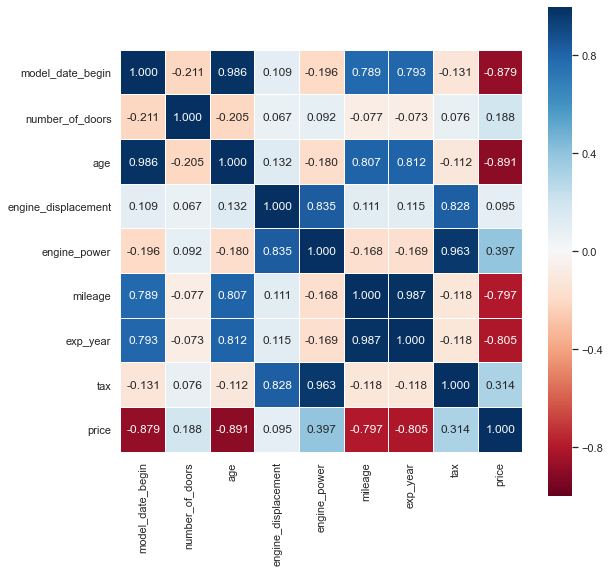

In [5]:
sns.set(font_scale=1)
plt.subplots(figsize=(9, 9))
sns.heatmap(train.iloc[:, numeric_idx].corr(), square=True,
            annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu", vmin=-1.0, vmax=1.0)

Из тепловой карты корреляций можно видеть, что есть признаки, у которых достаточно высокое значение корреляции: age и model_date_begin (0.986); exp_year и mileage (0.987); tax и engine_power (0.963). Проведенные эксперименты показали, что удаление признаков, которые порождают высокие значения корреляции не только не приводят к улучшению результата, но и ухудшают его, хоть и незначительно (1-2%). Было принято решение оставить эти признаки.  

Выделим тренировочные данные и целевую переменную:

In [6]:
X = train.drop(['price'], axis=1)
y = train.price.values

Сделаем разбиение на тренировочную и тестовую выборки:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

Выделим категориальные признаки для CatBoost, в датасете это признаки с типом object, number_of_doors и все параметры комплектации авто:

In [8]:
cat_features_ids = np.where(X_train.dtypes == object)[0].tolist()

In [9]:
cat_features_ids.append(5)

In [10]:
cat_features_ids.extend([i for i in range(15, 70)])

In [11]:
len(cat_features_ids)

65

In [12]:
X_train.columns[cat_features_ids]

Index(['body_type', 'color', 'fuel_type', 'name', 'vehicle_transmission',
       'gear_type', 'steering_wheel', 'owners', 'pts_origin',
       'number_of_doors', 'is_electro', 'exp_year', 'glonass',
       'wirelesscharger', 'ledlights', 'applecarplay', 'autopark',
       'laserlights', 'keylessentry', 'bodykit', 'highbeamassist',
       'paintmetallic', 'powerlatchingdoors', 'bas', 'electrotrunk',
       'activsuspension', 'frontseatsheatvent', 'projectiondisplay',
       'decorativeinteriorlighting', 'electronicgagepanel',
       'multizoneclimatecontrol', 'automirrors', 'adaptivelight',
       'tyrepressure', 'isofix', 'wheelheat', '360camera', 'usb', 'bluetooth',
       'asr', 'lightsensor', 'airbagcurtain', 'navigation', 'startbutton',
       'voicerecognition', 'rainsensor', 'collisionpreventionassist',
       '12vsocket', 'drl', 'airsuspension', 'lanekeepingassist', 'multiwheel',
       'blindspot', 'roofrails', 'passengerseatelectric', 'wheelleather',
       '22inchwheels', 'st

Запустим обучение: 

In [13]:
model = CatBoostRegressor(iterations=ITERATIONS,
                          learning_rate=LR,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                          )
model.fit(X_train, y_train,
          cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          )

0:	learn: 0.0531535	test: 0.0539107	best: 0.0539107 (0)	total: 258ms	remaining: 15m 2s
100:	learn: 0.0105250	test: 0.0104805	best: 0.0104805 (100)	total: 13.7s	remaining: 7m 39s
200:	learn: 0.0098136	test: 0.0099917	best: 0.0099917 (200)	total: 26.5s	remaining: 7m 15s
300:	learn: 0.0092820	test: 0.0096436	best: 0.0096436 (300)	total: 39.5s	remaining: 6m 59s
400:	learn: 0.0089616	test: 0.0094677	best: 0.0094677 (400)	total: 52.3s	remaining: 6m 44s
500:	learn: 0.0086798	test: 0.0092989	best: 0.0092989 (500)	total: 1m 5s	remaining: 6m 31s
600:	learn: 0.0084858	test: 0.0092243	best: 0.0092243 (600)	total: 1m 18s	remaining: 6m 18s
700:	learn: 0.0083154	test: 0.0091558	best: 0.0091558 (700)	total: 1m 31s	remaining: 6m 3s
800:	learn: 0.0081341	test: 0.0090949	best: 0.0090949 (800)	total: 1m 44s	remaining: 5m 51s
900:	learn: 0.0079961	test: 0.0090569	best: 0.0090566 (896)	total: 1m 57s	remaining: 5m 38s
1000:	learn: 0.0078835	test: 0.0090322	best: 0.0090322 (1000)	total: 2m 10s	remaining: 5m 2

Сделаем предсказание и сохраним в файл:

In [15]:
predict_submission = np.exp(model.predict(test))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.542822e+06
1,1,2.470811e+06
2,2,1.349958e+06
3,3,2.318480e+06
4,4,4.905925e+06
5,5,1.947622e+06
6,6,9.796271e+05
7,7,6.471031e+05
8,8,1.354326e+06
9,9,1.363314e+06


Посмотрим на важность признаков с точки зрения модели, рассмотрим первые 20 и последние 10 признаков. Из первого распределения следует, что тройка самых значимых признаков такова: возраст авто, количество лет прошедших с начала выпуска модели,пробег. Кроме того можно видеть, что новый признак tax 6 по порядку значимости, а exp_year 15. Три самых значимых параметра комплектации это glonass, paintmetallic, asr.

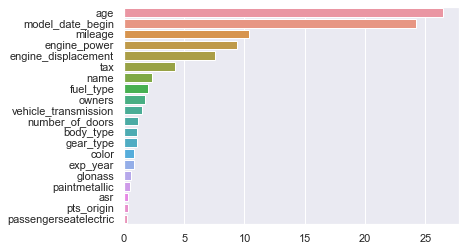

In [16]:
idx = np.flip(np.argsort(model.feature_importances_))
sns.barplot(x=model.feature_importances_[
            idx[:20]], y=np.array(model.feature_names_)[idx[:20]])

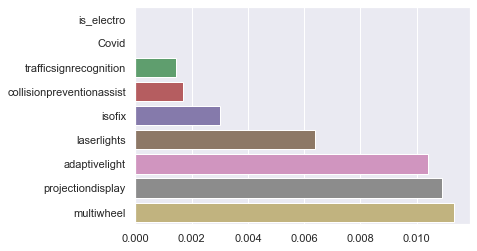

In [17]:
sns.barplot(x=model.feature_importances_[
            idx[:-10:-1]], y=np.array(model.feature_names_)[idx[:-10:-1]])

К сожалению, сгенерированные признаки is_electro и Covid оказались незначимы для модели. 

### Результат 

Лучшее значение метрики, которое удалось получить используя только CatBoost, равно **10.92**. 

## Blending

Для того, чтобы избежать возможного переобучения и улучшить качество предсказания выполним обучение модели на 5 фолдах, с дальнейшим объединением предсказаний от каждой модели. 

In [ ]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations=ITERATIONS,
                              learning_rate=LR,
                              eval_metric='MAPE',
                              random_seed=RANDOM_SEED,)
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)

    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
submissions = pd.DataFrame(0, columns=["sub_1"], index=sample_submission.index)
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True,
                    random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = np.exp(model.predict(test))
    model.save_model(f'catboost_fold_{idx+1}.model')

print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

Запишем полученный результат в файл:

In [ ]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv(f'submission_blend_v{VERSION}.csv', index=False)
sample_submission.head(10)

### Результат

Этот подход позволил улучшить значение метрики: теперь оно стало равным **10.61**. 